In [3]:
import os
import sys
import numpy as np
import pandas as pd
from nilearn import plotting
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action='ignore', category=UserWarning)

from src.pathology.core import determine_amyloid_status
from src.pathology.cutoffs import is_above_cutoff

from src.connectomics.atlases import fetch_dk_atlas, get_dk_hemisphere_mask
from src.connectomics.connectivity import merge_connectomes, get_norm_connectome_mask

# in
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))

df_dir = os.path.join(data_dir, 'bf2_20240927')
mri_fc_dir = os.path.join(data_dir, 'fc')
mri_sc_dir = os.path.join(data_dir, 'act')

df_fname = os.path.join(df_dir, 'toomas__20240927_090835.csv')
taupetqc_fname = os.path.join(df_dir, 'v2_tauPET_QC_for_database_June2023.xlsx')

# out
export_dir = os.path.join(data_dir, 'datasets')
os.makedirs(export_dir, exist_ok=True)

masks_dir = os.path.join(data_dir, 'masks')
os.makedirs(masks_dir, exist_ok=True)

_, dk_labels = fetch_dk_atlas()
dk_interhemi_mask = get_dk_hemisphere_mask(dk_labels, 'interhemi')

In [4]:
df = pd.read_csv(df_fname, low_memory=False)
print(f"N (raw) = {df.shape}")

tau_prefix = 'tnic'
cutoffs = {'cho_com_I_IV': 1.362}

# tau-PET
taupet_cols = [
    col for col in df.columns 
    if (col.startswith(f'{tau_prefix}_sr_mr_fs_ctx_') and 'unknown' not in col) or 
       (col.startswith(f'{tau_prefix}_sr_mr_fs_') and ('Hippocampus' in col or 'Amygdala' in col))
]

### healthy cohort selection

df = df[df['excluded']!=1].copy()
df = df.loc[df['study_cohort_baseline_variable'].isin(['BF2_A', 'BF2_B'])]
df = df.loc[df['diagnosis_baseline_variable'].isin(['Normal'])]
df = df.loc[df['underlying_etiology_text_baseline_variable'].isin(['Not_determined'])]
df = df.dropna(subset=taupet_cols)
df = df.loc[df['age']>50]
print(f"N (cohort selection) = {df.shape}")

### pathology

# amyloid status and forward fill from previous timepoints
df['amyloid_positive'] = df.apply(determine_amyloid_status, axis=1)
df = df.sort_values(by=['sid', 'Visit'])
df['amyloid_positive'] = df.groupby('sid')['amyloid_positive'].transform(lambda x: x.ffill())
df = df.loc[df['amyloid_positive']==0]
print(f"N (A-): {df.shape}")

# tau positivity status cho I-IV (temporal meta-ROI) and load in the most-affected hemisphere
df['tau_positive'] = is_above_cutoff(df[f'{tau_prefix}_cho_com_I_IV_L'], cutoffs['cho_com_I_IV']) | \
    is_above_cutoff(df[f'{tau_prefix}_cho_com_I_IV_R'], cutoffs['cho_com_I_IV'])
df = df.loc[df['tau_positive']==0]
print(f"N (T-): {df.shape}")

### tau-PET QC

df_qc = pd.read_excel(taupetqc_fname).sort_values(by='sid', ascending=True).reset_index(drop=True)
df = df.merge(df_qc[['mid', 'Exclude_tauPET', 'Comments_tauPET_pattern']], left_on='tau_pet_date__index', right_on='mid', how='left')
df = df[(df['Exclude_tauPET'] == 0) | (pd.isna(df['Exclude_tauPET']))].drop(columns=['mid_y', 'Exclude_tauPET'])
df = df.rename(columns={'mid_x': 'mid'})
df['raw_img_date_Tau_PET'] = pd.to_datetime(df['raw_img_date_Tau_PET'].astype(int).astype(str))
print(f"N (tau-PET QC) = {df.shape}")

N (raw) = (16034, 2896)
N (cohort selection) = (996, 2896)
N (A-): (790, 2897)
N (T-): (779, 2898)
N (tau-PET QC) = (776, 2899)


In [5]:
df_h = df.copy()

### FC

# read in dirs of all subjects
fc_subjects = next(os.walk(mri_fc_dir))[1]

# df setup for FC
df_fc = pd.DataFrame(data={'subject_fc_id': fc_subjects})
df_fc['mid'] = df_fc['subject_fc_id'].str.replace('_subject_id_', '', 1).str.split('__').str[0]
df_fc['fc_dir'] = df_fc['subject_fc_id'].apply(lambda x: os.path.join(mri_fc_dir, x))
df_fc['fc_mid_date'] = df_fc['subject_fc_id'].str.replace('_subject_id_', '', 1)
print(f"N (all FC) = {df_fc.shape}")

# merge FC dirs to main df & create file cols
df_h_fc = df_h.merge(df_fc, on='mid', how='left')
df_h_fc = df_h.merge(df_fc[['fc_mid_date', 'fc_dir']], left_on='mri_date__index', 
                          right_on='fc_mid_date', how='left')
df_h_fc['dk_fc_file'] = df_h_fc['fc_dir'].apply(
    lambda x: os.path.join(x, 'fc_aparcaseg.csv') if pd.notna(x) else np.nan)
print(f"N (FC merged to main; with NaNs) = {df_h_fc.shape}")
print(f"N (FC merged to main; without NaNs) = {df_h_fc.dropna(subset='fc_mid_date').shape}")

### SC

# read in dirs of all subjects+scans
sc_subjects = next(os.walk(mri_sc_dir))[1]
sc_subjects_scans = []
for sub in sc_subjects:
    scans = next(os.walk(os.path.join(mri_sc_dir, sub)))[1]
    for scan in scans:
        sc_subjects_scans.append([sub, scan])

# df setup for SC
df_sc = pd.DataFrame(data={'subject_scan_id': sc_subjects_scans})
df_sc['mid'] = df_sc['subject_scan_id'].apply(lambda x: x[0])
df_sc['date'] = df_sc['subject_scan_id'].apply(lambda x: x[1])
df_sc['sc_dir'] = df_sc.apply(lambda row: os.path.join(mri_sc_dir, row['mid'], row['date']), axis=1)
df_sc['sc_mid_date'] = (df_sc['mid'] + '__' + df_sc['date']).str[:-2]
print(f"N (all SC) = {df_sc.shape}")

# merge SC dirs to main df & create file cols
df_h_cc = df_h_fc.merge(df_sc[['sc_mid_date', 'sc_dir']], left_on='mri_date__index', 
                          right_on='sc_mid_date', how='left')
df_h_cc['dk_sc_file'] = df_h_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_sift2_10000000.csv') if pd.notna(x) else np.nan)
df_h_cc['dk_fa_file'] = df_h_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_fa_10000000.csv') if pd.notna(x) else np.nan)
df_h_cc['dk_md_file'] = df_h_cc['sc_dir'].apply(
    lambda x: os.path.join(x, 'sc_adc_10000000.csv') if pd.notna(x) else np.nan)
print(f"N (SC merged to main; with NaNs) = {df_h_cc.shape}")
print(f"N (SC merged to main; without NaNs) = {df_h_cc.dropna(subset='sc_mid_date').shape}")

### only both & first visit
df_h_cc = df_h_cc.dropna(subset=['dk_fc_file', 'dk_sc_file', 'dk_fa_file', 'dk_md_file'])
print(f"N (both modalities) = {df_h_cc.shape}")
df_h_cc = df_h_cc.loc[df_h_cc.groupby('sid')['Visit'].idxmin()]
print(f"N (first visit only) = {df_h_cc.shape}")

df_h_cc.to_csv(os.path.join(export_dir, f'bf2_tau_asymmetry_hc_xs_mri.csv'))

N (all FC) = (1327, 4)
N (FC merged to main; with NaNs) = (776, 2902)
N (FC merged to main; without NaNs) = (325, 2902)
N (all SC) = (1058, 5)
N (SC merged to main; with NaNs) = (777, 2907)
N (SC merged to main; without NaNs) = (367, 2907)
N (both modalities) = (295, 2907)
N (first visit only) = (294, 2907)


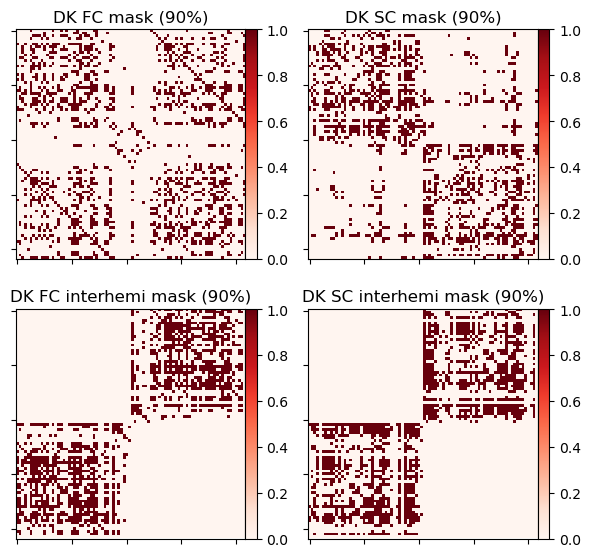

In [6]:
p = 90
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
for j, metric in enumerate(['fc', 'sc']):

    if metric == 'fc':
        drop_first_roi = True
        fisher = True
        replace_nan_with = None
    elif metric == 'sc': 
        drop_first_roi = False
        fisher = False
        replace_nan_with = None
    
    # merge HC group matrices together
    conn_params = dict(connectome_path_col=f'dk_{metric}_file', drop_first_roi=drop_first_roi, fisher=fisher, 
                       replace_nan_with=replace_nan_with, verbose=True)
    _, c_dk_full = merge_connectomes(df=df_h_cc, not_negative=True, mask=None, **conn_params)
    _, c_dk_interhemi = merge_connectomes(df=df_h_cc, not_negative=True, mask=dk_interhemi_mask, **conn_params)
    
    # get normative masks
    _, c_dk_n_mask_full = get_norm_connectome_mask(c_dk_full, mask=None, percentile=p)
    _, c_dk_n_mask_interhemi = get_norm_connectome_mask(c_dk_interhemi, mask=dk_interhemi_mask, percentile=p)

    # add the masks to dict
    data = [
        (c_dk_n_mask_full, f'DK {metric.upper()} mask ({p}%)', f'dk_n_{metric}_mask_{p}.npy'),
        (c_dk_n_mask_interhemi, f'DK {metric.upper()} interhemi mask ({p}%)', f'dk_n_{metric}_interhemi_mask_{p}.npy')
    ]

    # plot and export the masks
    for i, (mat, title, fname) in enumerate(data):
        plotting.plot_matrix(mat, cmap='Reds', axes=axs[i, j])
        axs[i, j].set_title(title)
        np.save(os.path.join(masks_dir, fname), mat)

plt.tight_layout()
plt.show()